In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sln
%matplotlib inline
#cleaning
import re
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,classification_report,roc_auc_score
#
from category_encoders.target_encoder import TargetEncoder

In [76]:
! pip3 install category_encoders

    100% |████████████████████████████████| 61kB 413kB/s ta 0:00:011
  Using cached https://files.pythonhosted.org/packages/e3/18/4f013c3c3051f4e0ffbaa4bf247050d6d5e527fe9cb1907f5975b172f23f/numpy-1.16.2-cp35-cp35m-manylinux1_x86_64.whl
    100% |████████████████████████████████| 10.0MB 99kB/s eta 0:00:01   33% |██████████▊                     | 3.4MB 1.2MB/s eta 0:00:06
    100% |████████████████████████████████| 5.3MB 173kB/s ta 0:00:011
    100% |████████████████████████████████| 24.7MB 40kB/s eta 0:00:011    58% |██████████████████▊             | 14.5MB 1.3MB/s eta 0:00:09
    100% |████████████████████████████████| 235kB 1.1MB/s ta 0:00:01
    100% |████████████████████████████████| 7.3MB 118kB/s ta 0:00:011
    100% |████████████████████████████████| 512kB 654kB/s ta 0:00:01
  Using cached https://files.pythonhosted.org/packages/41/17/c62faccbfbd163c7f57f3844689e3a78bae1f403648a6afb1d0866d87fbb/python_dateutil-2.8.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.o

In [84]:
#sklearn 
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.linear_model import LogisticRegressionCV

In [2]:
train=pd.read_csv('train.csv')

In [3]:
pd.set_option('display.max_columns', 500)

In [ ]:
train['loan_default'].value_counts()

In [68]:
train.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,03-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,26-09-18,6,1998,1,1,0,0,0,0,598,I-Medium Risk,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,01-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,26-10-18,6,1998,1,1,0,0,0,0,305,L-Very High Risk,3,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,26-09-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


In [163]:
#lets check whether balanced or unbalanced
print(train['loan_default'].value_counts()/train.shape[0])

0    0.782929
1    0.217071
Name: loan_default, dtype: float64


In [ ]:
train.isnull().sum()

In [28]:
#variables to modify
train['PERFORM_CNS.SCORE.DESCRIPTION'].value_counts()

No Bureau History Available                                116950
C-Very Low Risk                                             16045
A-Very Low Risk                                             14124
D-Very Low Risk                                             11358
B-Very Low Risk                                              9201
M-Very High Risk                                             8776
F-Low Risk                                                   8485
K-High Risk                                                  8277
H-Medium Risk                                                6855
E-Low Risk                                                   5821
I-Medium Risk                                                5557
G-Low Risk                                                   3988
Not Scored: Sufficient History Not Available                 3765
J-High Risk                                                  3748
Not Scored: Not Enough Info available on the customer        3672
Not Scored

In [61]:
#chi square test
cross=pd.crosstab(train['State_ID'],train['loan_default'])

In [62]:
from scipy.stats import chi2_contingency

In [63]:
chi2_contingency(cross)[1]

0.0

In [11]:
train_copy=train.copy(True)

In [ ]:
train['AVERAGE.ACCT.AGE'][0]

In [15]:
def change1(data,col):
    duration=[]
    
    for i in data[col]:
        dur=re.findall('\d+',i)
        duration.append(int(dur[0])*12+int(dur[1]))
    
    return duration

In [5]:
train_copy['AVERAGE.ACCT.AGE_num']=change1(train_copy,'AVERAGE.ACCT.AGE')

NameError: name 'train_copy' is not defined

In [ ]:
sln.distplot(train_copy[train_copy['loan_default']==0]['AVERAGE.ACCT.AGE_num'])
sln.distplot(train_copy[train_copy['loan_default']==1]['AVERAGE.ACCT.AGE_num'])
#avg.account.age>180 can be a feature

In [ ]:
train[['branch_id','loan_default']].groupby('branch_id').mean()['loan_default'].sort_values(ascending=False)[:5].plot('bar')

In [8]:
# will try to explore these branches for now removing all this
train_copy=train_copy.drop(['UniqueID','branch_id','supplier_id','manufacturer_id','Current_pincode_ID',
                           'Date.of.Birth','DisbursalDate','Employee_code_ID'],axis=1)

NameError: name 'train_copy' is not defined

In [4]:
col=['disbursed_amount','asset_cost',
        'ltv','PERFORM_CNS.SCORE','PRI.CURRENT.BALANCE','PRI.SANCTIONED.AMOUNT','PRI.DISBURSED.AMOUNT',
        'SEC.CURRENT.BALANCE','SEC.DISBURSED.AMOUNT','PRIMARY.INSTAL.AMT','SEC.INSTAL.AMT']

In [7]:
#target 
def calc_smooth_mean(df, by, on, m):
    # Compute the global mean
    mean = df[on].mean()

    # Compute the number of values and the mean of each group
    agg = df.groupby(by)[on].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    smooth = (counts * means + m * mean) / (counts + m)

    # Replace each value by the according smoothed mean
    return df[by].map(smooth)


In [21]:
#creating dummy for test and train
train_objs_num = len(train_copy)
dataset = pd.concat(objs=[train_copy, test], axis=0)
dataset_preprocessed = pd.get_dummies(dataset[['Employment.Type','State_ID','PERFORM_CNS.SCORE.DESCRIPTION']],drop_first=True)
train_preprocessed = dataset_preprocessed[:train_objs_num]
test_preprocessed = dataset_preprocessed[train_objs_num:]


/home/prakhar/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [65]:
te.fit_transform(train[tar_en],train['loan_default'])

,State_ID,PERFORM_CNS.SCORE.DESCRIPTION
0,6,0.231313
1,6,0.272629
2,6,0.231313
3,6,0.280423
4,6,0.231313
5,6,0.165746
6,6,0.231313
7,6,0.209695
8,6,0.149586
9,6,0.165746


In [ ]:
#my function
def convert(df):
    df=df.drop(['UniqueID','Date.of.Birth','DisbursalDate'],axis=1)
    #calling change 1
    
    
    
    df['AVERAGE.ACCT.AGE_num']=change1(df,'AVERAGE.ACCT.AGE')
    
    duration=[]
    df['CREDIT.HISTORY.LENGTH_num']=change1(df,'CREDIT.HISTORY.LENGTH')
    df=df.drop(['AVERAGE.ACCT.AGE','CREDIT.HISTORY.LENGTH'],axis=1)
    #target encoding
    #failing
#     te=TargetEncoder()
#     te.fit(df[tar_en],df['loan_default'])
#     en=te.fit_transform(df[tar_en],df['loan_default'])
    
    
    sc=StandardScaler()
    #print('hello')
    scaled_df=pd.DataFrame(sc.fit_transform(df[['disbursed_amount','asset_cost',
                                               'ltv','PERFORM_CNS.SCORE','PRI.CURRENT.BALANCE',
                                               'PRI.SANCTIONED.AMOUNT','PRI.DISBURSED.AMOUNT',
                                               'SEC.CURRENT.BALANCE','SEC.DISBURSED.AMOUNT',
                                               'PRIMARY.INSTAL.AMT','SEC.INSTAL.AMT']]),columns=col)
    df=df.drop(col,axis=1)
    #df=df.drop(['State_ID','PERFORM_CNS.SCORE.DESCRIPTION'],axis=1)
   
    #create dummyasset_cost
    #dummy=pd.get_dummies(df[['Employment.Type','State_ID','PERFORM_CNS.SCORE.DESCRIPTION']],drop_first=True)
    comb=pd.concat([df,train_preprocessed,scaled_df],axis=1)
    #print(comb.head(1))
    comb=comb.drop(['Employment.Type','State_ID','PERFORM_CNS.SCORE.DESCRIPTION'],axis=1)
    
    print('conversion done')
    return comb

In [23]:
final=convert(train_copy)

/home/prakhar/.local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/prakhar/.local/lib/python3.5/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


conversion done


In [24]:
final_new=final[final_col]

In [18]:
tar_en=['State_ID','PERFORM_CNS.SCORE.DESCRIPTION']

In [19]:
final.head()

NameError: name 'final' is not defined

In [16]:
final.shape

(233154, 55)

## feature selection

In [79]:
#lets try feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [80]:
sl=SelectKBest(f_classif,k=30)

In [81]:
sl.fit(final.drop('loan_default',axis=1), final['loan_default'])

/home/prakhar/.local/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [1] are constant.
  UserWarning)
/home/prakhar/.local/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


SelectKBest(k=30, score_func=<function f_classif at 0x7f371e029840>)

In [82]:
X_new = pd.DataFrame(SelectKBest(f_classif,k=15).fit_transform(final.drop('loan_default',axis=1), final['loan_default']))

/home/prakhar/.local/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [1] are constant.
  UserWarning)
/home/prakhar/.local/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


## TRUNCATED SVM

In [83]:
from sklearn.decomposition import TruncatedSVD
tr=TruncatedSVD(n_components=10)
tr.fit(X_new)
X_new=pd.DataFrame(tr.fit_transform(X_new))

## TRAINING

In [154]:
X_new.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1.0,1.0,0.0,6.0,0.231313,0.0,-0.291335,-0.921895,1.292133,-0.855453,-0.176064,-0.092010,-0.091711,-0.039323,-0.086581
1,1.0,1.0,0.0,6.0,0.272629,1.0,-0.555997,-0.544482,-0.132372,0.911822,-0.146773,-0.070871,-0.070599,-0.039323,-0.073427
2,1.0,1.0,0.0,6.0,0.231313,1.0,-0.083183,-0.765651,1.299116,-0.855453,-0.176064,-0.092010,-0.091711,-0.039323,-0.086581
3,1.0,1.0,0.0,6.0,0.280423,1.0,0.243307,-0.514764,1.198738,0.045917,-0.176064,-0.092010,-0.091711,-0.039323,-0.086376
4,1.0,1.0,0.0,6.0,0.231313,1.0,-0.152567,-0.821604,1.190882,-0.855453,-0.176064,-0.092010,-0.091711,-0.039323,-0.086581


In [115]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y),
                                                 y)

In [116]:
lr=LogisticRegressionCV(class_weight=class_weights,cv=2)

In [117]:
cross_cv=cross_validate(lr,X_new,final['loan_default'],cv=3,return_train_score=False,scoring='roc_auc')

/home/prakhar/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:1772: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if class_weight == "balanced":
/home/prakhar/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:676: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if class_weight == "balanced":
/home/prakhar/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:676: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if class_weight == "balanced":
/home/prakhar/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:676: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if class_weight == "balanced":
/home/prakhar/.

In [118]:
cross_cv['test_score'].mean()

0.612573433931686

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X_new, final['loan_default'], test_size=0.33, random_state=42)


In [120]:
#train
lr.fit(X_train,y_train)

/home/prakhar/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:1772: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if class_weight == "balanced":
/home/prakhar/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:676: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if class_weight == "balanced":
/home/prakhar/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:676: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if class_weight == "balanced":
/home/prakhar/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:676: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if class_weight == "balanced":


LogisticRegressionCV(Cs=10, class_weight=array([0.63863, 2.30339]), cv=2,
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

In [121]:
pred=lr.predict(X_test)

In [122]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88     60178
           1       0.29      0.00      0.00     16763

   micro avg       0.78      0.78      0.78     76941
   macro avg       0.54      0.50      0.44     76941
weighted avg       0.68      0.78      0.69     76941



In [123]:
confusion_matrix(y_test,pred)

array([[60166,    12],
       [16758,     5]])

In [124]:
roc_auc_score(y_test,pred)

0.5000494337716203

In [ ]:
te.transform(test[tar_en],)

## PREDICTION

In [7]:
test=pd.read_csv('test_bqCt9Pv.csv')

4     25568
6     15398
3     13790
8      5850
13     5669
9      5437
1      5415
15     4797
11     4753
5      4127
7      3842
14     3637
18     3225
2      3098
16     2425
10     1959
17     1522
12     1082
19      379
21      238
20      121
22       60
Name: State_ID, dtype: int64

In [25]:

def convert_test(df):
    df=df.drop(['UniqueID',
                           'Date.of.Birth','DisbursalDate'],axis=1)
    #calling change 1
    
    
    
    df['AVERAGE.ACCT.AGE_num']=change1(df,'AVERAGE.ACCT.AGE')
    
    duration=[]
    df['CREDIT.HISTORY.LENGTH_num']=change1(df,'CREDIT.HISTORY.LENGTH')
    df=df.drop(['AVERAGE.ACCT.AGE','CREDIT.HISTORY.LENGTH'],axis=1)
    #target encoding
    #failing
#     te=TargetEncoder()
#     te.fit(df[tar_en],df['loan_default'])
#     en=te.fit_transform(df[tar_en],df['loan_default'])
    
    
    sc=StandardScaler()
    #print('hello')
    scaled_df=pd.DataFrame(sc.fit_transform(df[['disbursed_amount','asset_cost',
                                               'ltv','PERFORM_CNS.SCORE','PRI.CURRENT.BALANCE',
                                               'PRI.SANCTIONED.AMOUNT','PRI.DISBURSED.AMOUNT',
                                               'SEC.CURRENT.BALANCE','SEC.DISBURSED.AMOUNT',
                                               'PRIMARY.INSTAL.AMT','SEC.INSTAL.AMT']]),columns=col)
    df=df.drop(col,axis=1)
    #df=df.drop(['State_ID','PERFORM_CNS.SCORE.DESCRIPTION'],axis=1)
   
    #create dummyasset_cost
    #dummy=pd.get_dummies(df[['Employment.Type','State_ID','PERFORM_CNS.SCORE.DESCRIPTION']],drop_first=True)
    comb=pd.concat([df,test_preprocessed,scaled_df],axis=1)
    #print(comb.head(1))
    comb=comb.drop(['Employment.Type','State_ID','PERFORM_CNS.SCORE.DESCRIPTION'],axis=1)
    
    print('conversion done')
    return comb

In [26]:
test_con=convert_test(test)

conversion done


/home/prakhar/.local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/prakhar/.local/lib/python3.5/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [27]:
test_new=test_con[final_col]

In [102]:
test_con.shape

(112392, 10)

In [104]:
test_best=pd.DataFrame(sl.transform(test_con))

In [105]:
tr.fit(test_best)
test_best=pd.DataFrame(tr.fit_transform(test_best))

In [106]:
pred_test=lr.predict(test_best)

In [30]:
my_sub=pd.DataFrame({'UniqueID':test.UniqueID,'loan_default':result['predict']})

In [31]:
my_sub.to_csv('sub10.csv',index=False)

# difference of algo xgboost

In [126]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

/home/prakhar/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [182]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)


In [27]:

y=final['loan_default']

In [183]:
x_train = X_new.as_matrix()

/home/prakhar/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [184]:
xgb1.fit(x_train,y,eval_metric='auc')

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8)

In [186]:
pred_xgb=xgb1.predict(test_best.as_matrix())

/home/prakhar/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


## using bayesian optimization

In [34]:
import lightgbm as lgb
from hyperopt import STATUS_OK

N_FOLDS = 10
from hyperopt import hp

# Create the dataset
train_set = lgb.Dataset(X_new, final['loan_default'])

def objective(params, n_folds = N_FOLDS):
    """Objective function for Gradient Boosting Machine Hyperparameter Tuning"""
    
    # Perform n_fold cross validation with hyperparameters
    # Use early stopping and evalute based on ROC AUC
    cv_results = lgb.cv(params, train_set, nfold = n_folds, num_boost_round = 10000, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 50,class_weight='balance')
  
    # Extract the best score
    best_score = max(cv_results['auc-mean'])
    
    # Loss must be minimized
    loss = 1 - best_score
    
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [32]:
space = {
    'class_weight': 'balanced',
    
    'num_leaves': hp.quniform('num_leaves', 30, 150, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0)
}

In [26]:
boosting_type = {'boosting_type': hp.choice('boosting_type', 
                                            [{'boosting_type': 'gbdt', 
                                                  'subsample': hp.uniform('subsample', 0.5, 1)}, 
                                             {'boosting_type': 'dart', 
                                                  'subsample': hp.uniform('subsample', 0.5, 1)},
                                             {'boosting_type': 'goss',
                                                  'subsample': 1.0}])}

In [24]:
example = sample(space)

# Dictionary get method with default
subsample = example['boosting_type'].get('subsample', 1.0)

# Assign top-level keys
example['boosting_type'] = example['boosting_type']['boosting_type']
example['subsample'] = subsample

NameError: name 'sample' is not defined

In [21]:
from hyperopt import Trials
# Trials object to track progress
bayes_trials = Trials()


In [22]:
from hyperopt import tpe
# Algorithm
tpe_algorithm = tpe.suggest

In [35]:
from hyperopt import fmin

MAX_EVALS = 500

# Optimize
best = fmin(fn = objective, space = space, algo = tpe.suggest, 
            max_evals = MAX_EVALS, trials = bayes_trials)

TypeError: cv() got an unexpected keyword argument 'class_weight'

In [36]:
import lgb
# Default gradient boosting machine classifier
model = lgb.LGBMClassifier()
model
LGBMClassifier(boosting_type='gbdt', n_estimators=100,
               class_weight=None, colsample_bytree=1.0,
               learning_rate=0.1, max_depth=-1,                      
               min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, 
               n_jobs=-1, num_leaves=31, objective=None, 
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, 
               silent=True, subsample=1.0, 
               subsample_for_bin=200000, subsample_freq=1)

ImportError: No module named 'lgb'

In [37]:
! pip3 install lgb

  Could not find a version that satisfies the requirement lgb (from versions: )
No matching distribution found for lgb
You are using pip version 8.1.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [41]:
import lightgbm as lgb

In [48]:
lg=lgb.LGBMClassifier()

In [49]:
lg.fit(X_new,y)

/home/prakhar/.local/lib/python3.5/site-packages/lightgbm/engine.py:163: UserWarning: Using Pandas (default) integer column names, not column indexes. You can use indexes with DataFrame.values.
  booster = Booster(params=params, train_set=train_set)


LGBMClassifier(boosting_type='gbdt', colsample_bytree=1, learning_rate=0.1,
        max_bin=255, max_depth=-1, min_child_samples=10,
        min_child_weight=5, min_split_gain=0, n_estimators=10, nthread=-1,
        num_leaves=31, objective='binary', reg_alpha=0, reg_lambda=0,
        seed=0, silent=True, subsample=1, subsample_for_bin=50000,
        subsample_freq=1)

In [55]:
pred_lgb=lg.predict(test_best)

/home/prakhar/.local/lib/python3.5/site-packages/lightgbm/sklearn.py:543: UserWarning: Using Pandas (default) integer column names, not column indexes. You can use indexes with DataFrame.values.
  class_probs = self.predict_proba(X, raw_score, num_iteration)


## check for data leakage

In [59]:
train_copy.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,03-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,26-09-18,6,1998,1,1,0,0,0,0,598,I-Medium Risk,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,01-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,26-10-18,6,1998,1,1,0,0,0,0,305,L-Very High Risk,3,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,26-09-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


In [60]:
train_copy[['State_ID','loan_default']].groupby('State_ID').mean()

,loan_default
State_ID,
1,0.177149
2,0.271394
3,0.186191
4,0.207845
5,0.198782
6,0.205641
7,0.201739
8,0.229485
9,0.217950


In [70]:
train_copy['State_ID'].value_counts()/train_copy.shape[0]*100

4     19.244791
3     14.616091
6     14.370330
13     7.670467
9      6.871853
8      6.089108
5      4.364926
14     4.037675
1      3.832660
7      2.910523
11     2.882644
18     2.321213
15     2.165522
12     1.805674
2      1.784228
17     1.711744
10     1.546188
16     1.151599
19     0.443913
20     0.079347
21     0.066909
22     0.032596
Name: State_ID, dtype: float64

In [71]:
train_copy['PERFORM_CNS.SCORE.DESCRIPTION'].value_counts()/train_copy.shape[0]*100

No Bureau History Available                                50.159980
C-Very Low Risk                                             6.881718
A-Very Low Risk                                             6.057799
D-Very Low Risk                                             4.871458
B-Very Low Risk                                             3.946319
M-Very High Risk                                            3.764036
F-Low Risk                                                  3.639226
K-High Risk                                                 3.550014
H-Medium Risk                                               2.940117
E-Low Risk                                                  2.496633
I-Medium Risk                                               2.383403
G-Low Risk                                                  1.710457
Not Scored: Sufficient History Not Available                1.614813
J-High Risk                                                 1.607521
Not Scored: Not Enough Info availa

In [69]:
train_copy[['PERFORM_CNS.SCORE.DESCRIPTION','loan_default']].groupby('PERFORM_CNS.SCORE.DESCRIPTION').mean()

,loan_default
PERFORM_CNS.SCORE.DESCRIPTION,
A-Very Low Risk,0.165746
B-Very Low Risk,0.131290
C-Very Low Risk,0.172639
D-Very Low Risk,0.149586
E-Low Risk,0.171792
F-Low Risk,0.186211
G-Low Risk,0.197091
H-Medium Risk,0.241867
I-Medium Risk,0.272629


## Bi Variate Analysis

In [125]:
def bi_variate(df,col1):
    sln.distplot(np.log1p(df[df['loan_default']==1][col1]),label='default')
    sln.distplot(np.log1p(df[df['loan_default']==0][col1]),label='non-default')
    plt.legend(['default','non-default'])

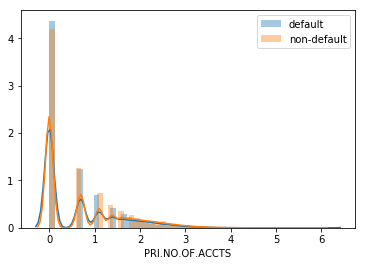

In [91]:
bi_variate(train,'PRI.NO.OF.ACCTS')

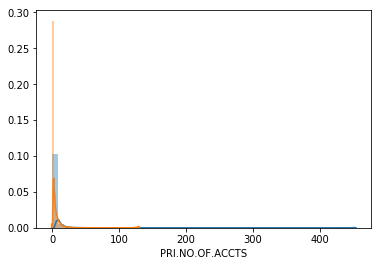

In [129]:
sln.distplot(train['PRI.NO.OF.ACCTS'])
sln.distplot(test['PRI.NO.OF.ACCTS'])

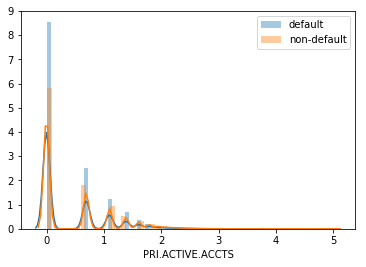

In [92]:
bi_variate(train,'PRI.ACTIVE.ACCTS')

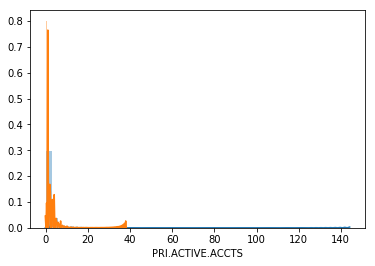

In [130]:
sln.distplot(train['PRI.ACTIVE.ACCTS'])
sln.distplot(test['PRI.ACTIVE.ACCTS'])

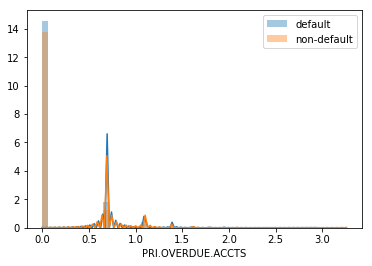

In [93]:
bi_variate(train,'PRI.OVERDUE.ACCTS')

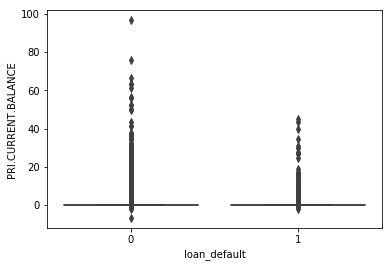

In [102]:
sln.boxplot(train['loan_default'],train['PRI.CURRENT.BALANCE']/1000000)

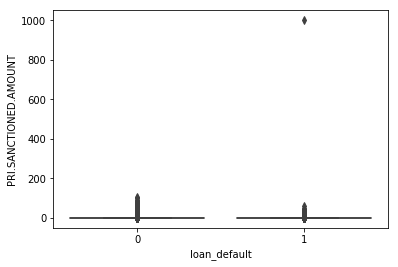

In [105]:
sln.boxplot(train['loan_default'],train['PRI.SANCTIONED.AMOUNT']/1000000)

In [108]:
train[['Employee_code_ID','loan_default']].groupby('Employee_code_ID').mean()

,loan_default
Employee_code_ID,
1,0.262500
3,0.442953
4,0.313433
5,0.191919
7,0.111111
9,0.303571
10,0.181818
11,0.152941
12,0.168067


In [23]:
X_new['Emp_id']=train['Employee_code_ID']

## ONE Class svm

In [109]:
from sklearn.svm import LinearSVC

In [110]:
clf = LinearSVC(penalty='l2',class_weight='balanced')

In [111]:
clf.fit(X_new,y)

/home/prakhar/.local/lib/python3.5/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [112]:
pred_svm = clf.predict(test_best)

## checking whether it is data mismatch or variance error

In [131]:
train.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,03-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,26-09-18,6,1998,1,1,0,0,0,0,598,I-Medium Risk,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,01-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,26-10-18,6,1998,1,1,0,0,0,0,305,L-Very High Risk,3,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,26-09-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


In [132]:
X_new.head()

,0,1,2,3,4,5,6,7,8,9
0,0.004198,0.015400,-0.103884,-0.485751,1.646916,-1.125819,0.431619,-0.251696,-0.072246,-0.033996
1,23.034175,-1.240992,-0.468382,-0.526280,-0.396265,-0.506329,-0.250916,-0.377767,1.257250,-0.337957
2,0.004284,0.016943,-0.149018,-0.379087,1.746280,-0.996954,0.373855,-0.261223,-0.066983,-0.029036
3,15.231794,1.288350,0.481546,0.666358,1.148000,-1.081458,-0.592696,0.381978,0.013954,0.203702
4,0.008385,0.047623,-0.219720,-0.510339,1.742333,-1.221637,-0.186271,0.528183,-0.105840,0.027238


In [133]:
X_new.shape

(233154, 10)

In [134]:
train.shape

(233154, 41)

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X_new, final['loan_default'], test_size=0.2, random_state=42)

In [136]:
X_train.shape

(186523, 10)

In [137]:
X_train, X_bridge, y_train, y_bridge = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [138]:
X_train.shape

(149218, 10)

In [139]:
X_test.shape

(46631, 10)

In [140]:
X_bridge.shape

(37305, 10)

In [141]:
lr.fit(X_train,y_train)

/home/prakhar/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:1772: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if class_weight == "balanced":
/home/prakhar/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:676: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if class_weight == "balanced":
/home/prakhar/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:676: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if class_weight == "balanced":
/home/prakhar/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:676: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if class_weight == "balanced":


LogisticRegressionCV(Cs=10, class_weight=array([0.63863, 2.30339]), cv=2,
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

In [142]:
pred_bridge=lr.predict(X_bridge)

In [144]:
roc_auc_score(y_bridge,pred_bridge)

0.5000112473263142

In [145]:
pred_dev=lr.predict(X_test)

In [146]:
roc_auc_score(y_test,pred_dev)

0.5000654814289094

In [147]:
#cross validation score
cross_cv=cross_validate(lr,X_train,y_train,cv=2,return_train_score=False,scoring='roc_auc')

/home/prakhar/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:1772: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if class_weight == "balanced":
/home/prakhar/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:676: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if class_weight == "balanced":
/home/prakhar/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:676: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if class_weight == "balanced":
/home/prakhar/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:676: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if class_weight == "balanced":
/home/prakhar/.

In [149]:
cross_cv['test_score'].mean()

0.6080064556386894

## Trying automl H20

In [1]:
import h2o

In [102]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator

In [4]:
h2o.init()



Checking whether there is an H2O instance running at http://localhost:54321..... not found.


H2OServerError: Cluster reports unhealthy status

In [5]:
h2o.cluster().show_status()

AttributeError: 'NoneType' object has no attribute 'show_status'

In [22]:
final_new['loan_default']=train['loan_default']

/home/prakhar/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [ ]:
final_new['loa']

In [23]:
hf_new = h2o.H2OFrame(final_new)

/home/prakhar/.local/lib/python3.5/site-packages/h2o/utils/shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%


In [24]:
hf_new['loan_default'] = hf_new['loan_default'].asfactor()

In [92]:
hf_new.head()

ltv,Current_pincode_ID,PERFORM_CNS.SCORE,disbursed_amount,branch_id,CREDIT.HISTORY.LENGTH_num,manufacturer_id,supplier_id,Employee_code_ID,NO.OF_INQUIRIES,PRI.SANCTIONED.AMOUNT,PRI.NO.OF.ACCTS,asset_cost,loan_default
1.29213,1441,-0.855453,-0.291335,67,0,45,22807,1998,0,-0.0920098,0,-0.921895,0
-0.132372,1502,0.911822,-0.555997,67,23,45,22807,1998,0,-0.0708711,1,-0.544482,1
1.29912,1497,-0.855453,-0.0831832,67,0,45,22807,1998,0,-0.0920098,0,-0.765651,0
1.19874,1501,0.0459167,0.243307,67,15,45,22807,1998,1,-0.0920098,3,-0.514764,1
1.19088,1495,-0.855453,-0.152567,67,0,45,22807,1998,1,-0.0920098,0,-0.821604,1
1.30173,1501,1.58268,0.0120271,67,24,45,22807,1998,0,-0.0920098,2,-0.737147,0
0.14607,1502,-0.855453,-0.617363,67,0,45,22807,1998,0,-0.0920098,0,-0.758262,0
-0.249335,1501,-0.805212,-0.806627,67,2,45,22807,1998,0,-0.0606386,1,-0.737147,0
1.29301,1497,1.26646,-0.0496476,67,56,45,22807,1998,1,0.0618498,1,-0.733294,0
1.06519,1492,1.56199,-0.135221,67,19,45,22807,1998,0,-0.0920098,1,-0.768819,0


In [25]:
predictors = final_new.drop('loan_default',axis=1).columns.tolist()
response = 'loan_default'

In [100]:
type(predictors)

list

In [26]:
train_new, valid_new = hf_new.split_frame(ratios = [.8], seed = 1234)

In [93]:
train_new.head()

ltv,Current_pincode_ID,PERFORM_CNS.SCORE,disbursed_amount,branch_id,CREDIT.HISTORY.LENGTH_num,manufacturer_id,supplier_id,Employee_code_ID,NO.OF_INQUIRIES,PRI.SANCTIONED.AMOUNT,PRI.NO.OF.ACCTS,asset_cost,loan_default
1.29213,1441,-0.855453,-0.291335,67,0,45,22807,1998,0,-0.0920098,0,-0.921895,0
-0.132372,1502,0.911822,-0.555997,67,23,45,22807,1998,0,-0.0708711,1,-0.544482,1
1.29912,1497,-0.855453,-0.0831832,67,0,45,22807,1998,0,-0.0920098,0,-0.765651,0
1.19088,1495,-0.855453,-0.152567,67,0,45,22807,1998,1,-0.0920098,0,-0.821604,1
1.30173,1501,1.58268,0.0120271,67,24,45,22807,1998,0,-0.0920098,2,-0.737147,0
0.14607,1502,-0.855453,-0.617363,67,0,45,22807,1998,0,-0.0920098,0,-0.758262,0
-0.249335,1501,-0.805212,-0.806627,67,2,45,22807,1998,0,-0.0606386,1,-0.737147,0
1.29301,1497,1.26646,-0.0496476,67,56,45,22807,1998,1,0.0618498,1,-0.733294,0
1.31657,1493,0.0311401,-0.0831832,67,7,45,22807,1998,0,-0.0920098,1,-0.772514,1
1.2642,1446,1.46742,0.802697,67,27,45,22807,1998,1,-0.0767857,3,-0.0884186,0


In [103]:
cov_gbm = H2OGradientBoostingEstimator(balance_classes = True, seed = 1234)
cov_gbm.train(x = predictors, y = response, training_frame = train_new, validation_frame = valid_new)

H2OResponseError: ModelBuilderErrorV3  (water.exceptions.H2OModelBuilderIllegalArgumentException):
    parameters = {'validation_frame': None, 'nbins_top_level': 1024, 'score_tree_interval': 0, 'response_column': {'__meta': {'schema_name': 'ColSpecifierV3', 'schema_type': 'VecSpecifier', 'schema_version': 3}, 'column_name': 'loan_default', 'is_member_of_frames': None}, 'r2_stopping': 1.7976931348623157e+308, 'fold_assignment': 'AUTO', 'distribution': 'AUTO', 'max_abs_leafnode_pred': 1.7976931348623157e+308, 'nfolds': 0, 'col_sample_rate_per_tree': 1.0, 'stopping_tolerance': 0.001, 'min_rows': 10.0, 'sample_rate_per_class': None, 'quantile_alpha': 0.5, 'min_split_improvement': 1e-05, 'col_sample_rate_change_per_level': 1.0, 'learn_rate': 0.1, 'class_sampling_factors': None, 'training_frame': None, 'pred_noise_bandwidth': 0.0, 'ntrees': 50, 'offset_column': None, 'ignored_columns': None, 'seed': 1234, 'huber_alpha': 0.9, 'sample_rate': 1.0, 'nbins': 20, 'calibration_frame': None, 'weights_column': None, 'model_id': None, 'max_confusion_matrix_size': 20, 'parallelize_cross_validation': True, 'score_each_iteration': False, 'histogram_type': 'AUTO', 'tweedie_power': 1.5, 'stopping_rounds': 0, 'learn_rate_annealing': 1.0, 'max_after_balance_size': 5.0, 'nbins_cats': 1024, 'stopping_metric': 'AUTO', 'keep_cross_validation_predictions': False, 'max_hit_ratio_k': 0, 'max_depth': 5, 'max_runtime_secs': 0.0, '__meta': {'schema_name': 'GBMParametersV3', 'schema_type': 'GBMParameters', 'schema_version': 3}, 'build_tree_one_node': False, 'categorical_encoding': 'AUTO', 'calibrate_model': False, 'ignore_const_cols': True, 'checkpoint': None, 'keep_cross_validation_fold_assignment': False, 'balance_classes': True, 'col_sample_rate': 1.0, 'fold_column': None, 'max_categorical_levels': 10, 'custom_metric_func': None}
    timestamp = 1555855236947
    http_status = 412
    values = {'algo': 'GBM', 'parameters': {'_max_categorical_levels': 10, '_col_sample_rate_change_per_level': 1.0, '_huber_alpha': 0.9, '_keep_cross_validation_predictions': False, '_initial_score_interval': 4000, '_min_split_improvement': 1e-05, '_sample_rate': 1.0, '_ignore_const_cols': True, '_pretrained_autoencoder': None, '_nbins_top_level': 1024, '_response_column': 'loan_default', '_custom_metric_func': None, '_col_sample_rate': 1.0, '_score_interval': 4000, '_min_rows': 10.0, '_weights_column': None, '_max_confusion_matrix_size': 20, '_balance_classes': True, '_max_after_balance_size': 5.0, '_categorical_encoding': 'AUTO', '_learn_rate_annealing': 1.0, '_score_tree_interval': 0, '_fold_assignment': 'AUTO', '_ntrees': 50, '_train': {'type': 'Key', 'name': 'py_22_sid_93e0'}, '_r2_stopping': 1.7976931348623157e+308, '_max_depth': 5, '_ignored_columns': None, '_stopping_metric': 'AUTO', '_pred_noise_bandwidth': 0.0, '_build_tree_one_node': False, '_quantile_alpha': 0.5, '_distribution': 'AUTO', '_nbins': 20, '_max_runtime_secs': 0.0, '_seed': 1234, '_calibrate_model': False, '_class_sampling_factors': None, '_sample_rate_per_class': None, '_tweedie_power': 1.5, '_nbins_cats': 1024, '_parallelize_cross_validation': True, '_learn_rate': 0.1, '_fold_column': None, '_calibration_frame': None, '_keep_cross_validation_fold_assignment': False, '_offset_column': None, '_stopping_rounds': 0, '_valid': {'type': 'Key', 'name': 'py_24_sid_93e0'}, '_auto_rebalance': True, '_stopping_tolerance': 0.001, '_nfolds': 0, '_checkpoint': None, '_max_abs_leafnode_pred': 1.7976931348623157e+308, '_is_cv_model': False, '_score_each_iteration': False, '_histogram_type': 'AUTO', '_col_sample_rate_per_tree': 1.0}, 'messages': [{'_log_level': 1, '_message': 'Missing training frame: py_22_sid_93e0', '_field_name': '_train'}], 'error_count': 2}
    messages = [{'__meta': {'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage', 'schema_version': 3}, 'field_name': 'train', 'message': 'Missing training frame: py_22_sid_93e0', 'message_type': 'ERRR'}]
    stacktrace =
        water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: GBM_model_python_1555855161988_1.  Details: ERRR on field: _train: Missing training frame: py_22_sid_93e0
        water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
        hex.ModelBuilder.trainModel(ModelBuilder.java:239)
        water.api.ModelBuilderHandler.handle(ModelBuilderHandler.java:64)
        water.api.ModelBuilderHandler.handle(ModelBuilderHandler.java:17)
        water.api.RequestServer.serve(RequestServer.java:451)
        water.api.RequestServer.doGeneric(RequestServer.java:296)
        water.api.RequestServer.doPost(RequestServer.java:222)
        javax.servlet.http.HttpServlet.service(HttpServlet.java:755)
        javax.servlet.http.HttpServlet.service(HttpServlet.java:848)
        org.eclipse.jetty.servlet.ServletHolder.handle(ServletHolder.java:684)
        org.eclipse.jetty.servlet.ServletHandler.doHandle(ServletHandler.java:503)
        org.eclipse.jetty.server.handler.ContextHandler.doHandle(ContextHandler.java:1086)
        org.eclipse.jetty.servlet.ServletHandler.doScope(ServletHandler.java:429)
        org.eclipse.jetty.server.handler.ContextHandler.doScope(ContextHandler.java:1020)
        org.eclipse.jetty.server.handler.ScopedHandler.handle(ScopedHandler.java:135)
        org.eclipse.jetty.server.handler.HandlerCollection.handle(HandlerCollection.java:154)
        org.eclipse.jetty.server.handler.HandlerWrapper.handle(HandlerWrapper.java:116)
        water.JettyHTTPD$LoginHandler.handle(JettyHTTPD.java:197)
        org.eclipse.jetty.server.handler.HandlerCollection.handle(HandlerCollection.java:154)
        org.eclipse.jetty.server.handler.HandlerWrapper.handle(HandlerWrapper.java:116)
        org.eclipse.jetty.server.Server.handle(Server.java:370)
        org.eclipse.jetty.server.AbstractHttpConnection.handleRequest(AbstractHttpConnection.java:494)
        org.eclipse.jetty.server.BlockingHttpConnection.handleRequest(BlockingHttpConnection.java:53)
        org.eclipse.jetty.server.AbstractHttpConnection.content(AbstractHttpConnection.java:982)
        org.eclipse.jetty.server.AbstractHttpConnection$RequestHandler.content(AbstractHttpConnection.java:1043)
        org.eclipse.jetty.http.HttpParser.parseNext(HttpParser.java:865)
        org.eclipse.jetty.http.HttpParser.parseAvailable(HttpParser.java:240)
        org.eclipse.jetty.server.BlockingHttpConnection.handle(BlockingHttpConnection.java:72)
        org.eclipse.jetty.server.bio.SocketConnector$ConnectorEndPoint.run(SocketConnector.java:264)
        org.eclipse.jetty.util.thread.QueuedThreadPool.runJob(QueuedThreadPool.java:608)
        org.eclipse.jetty.util.thread.QueuedThreadPool$3.run(QueuedThreadPool.java:543)
        java.lang.Thread.run(Thread.java:748)
    msg = 'Illegal argument(s) for GBM model: GBM_model_python_1555855161988_1.  Details: ERRR on field: _train: Missing training frame: py_22_sid_93e0'
    error_count = 2
    exception_msg = 'Illegal argument(s) for GBM model: GBM_model_python_1555855161988_1.  Details: ERRR on field: _train: Missing training frame: py_22_sid_93e0'
    error_url = '/3/ModelBuilders/gbm'
    dev_msg = 'Illegal argument(s) for GBM model: GBM_model_python_1555855161988_1.  Details: ERRR on field: _train: Missing training frame: py_22_sid_93e0'


In [171]:
print('auc', cov_gbm.auc(valid = True))

auc 0.6410572472637638


In [172]:
from h2o.grid.grid_search import H2OGridSearch

# select the values for `balance_classes` to grid over
hyper_params = {'balance_classes': [True, False]}


In [173]:
cov_gbm_2 = H2OGradientBoostingEstimator(seed = 1234)

In [174]:
grid = H2OGridSearch(model = cov_gbm_2, hyper_params = hyper_params,
                     search_criteria = {'strategy': "Cartesian"})


In [175]:
grid.train(x = predictors, y = response, training_frame = train, validation_frame = valid)


gbm Grid Build progress: |████████████████████████████████████████████████| 100%


In [1]:
sorted_grid = grid.get_grid(sort_by='rmse', decreasing=False)
print(sorted_grid)

NameError: name 'grid' is not defined

In [201]:
grid.predict()

    balance_classes  \
0             false   
1              true   

                                                      model_ids  \
0  Grid_GBM_py_4_sid_861b_model_python_1555744403672_22_model_1   
1  Grid_GBM_py_4_sid_861b_model_python_1555744403672_22_model_0   

              logloss  
0  0.5002174837069485  
1  0.5004907713253698  


<bound method H2OGridSearch.get_grid of >

In [27]:
hf_test = h2o.H2OFrame(test_new)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [202]:
pred_h20=cov_gbm.predict(hf_test)

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [203]:
result=pred_h20.as_data_frame()

In [205]:
result['predict']

0         1
1         1
2         1
3         0
4         1
5         1
6         1
7         1
8         1
9         1
10        0
11        1
12        0
13        0
14        0
15        0
16        0
17        1
18        1
19        0
20        1
21        1
22        1
23        1
24        1
25        0
26        1
27        0
28        0
29        0
         ..
112362    1
112363    1
112364    1
112365    0
112366    1
112367    0
112368    0
112369    1
112370    0
112371    1
112372    0
112373    0
112374    0
112375    0
112376    1
112377    0
112378    0
112379    1
112380    1
112381    0
112382    0
112383    1
112384    0
112385    1
112386    1
112387    0
112388    1
112389    0
112390    1
112391    0
Name: predict, Length: 112392, dtype: int64

In [28]:
from h2o.automl import H2OAutoML

In [29]:
aml = H2OAutoML(max_models=5 ,seed=1,balance_classes=True,sort_metric='auc')

In [ ]:
aml.train(x=predictors, y=response, training_frame=train_new,validation_frame=valid_new)

AutoML progress: |███████████████████████████████████████████████████████

In [24]:
lb = aml.leaderboard

In [25]:
lb.head(rows=lb.nrows)

model_id,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_0_AutoML_20190421_175941,0.657505,0.497187,0.386612,0.401531,0.161227
StackedEnsemble_BestOfFamily_0_AutoML_20190421_175941,0.656733,0.497423,0.38622,0.401611,0.161292
GBM_grid_0_AutoML_20190421_175941_model_1,0.656431,0.497305,0.38657,0.401636,0.161312
GBM_grid_0_AutoML_20190421_175941_model_0,0.65604,0.497476,0.386476,0.401764,0.161415
XRT_0_AutoML_20190421_175941,0.637508,0.509563,0.401518,0.406027,0.164858
DRF_0_AutoML_20190421_175941,0.637448,0.509848,0.402328,0.40602,0.164852
GLM_grid_0_AutoML_20190421_175941_model_0,0.631281,0.505403,0.407357,0.404972,0.164003


In [26]:
h2o.save_model(aml.leader)

'/home/prakhar/Desktop/lnt/StackedEnsemble_AllModels_0_AutoML_20190421_175941'

In [28]:
preds = aml.leader.predict(hf_test)

stackedensemble prediction progress: |████████████████████████████████████| 100%


In [29]:
result=preds.as_data_frame()

# checking for covariate shift

In [34]:
final['is_train']=1
test_con['is_train']=0

In [36]:
df_combine = pd.concat([final, test_con], axis=0, ignore_index=True)
df_combine = df_combine.drop('loan_default', axis =1)


/home/prakhar/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [38]:
y = df_combine['is_train'].values #labels
x = df_combine.drop('is_train', axis=1).values #covariates or our independent variables

In [39]:
tst, trn = test_con.values, final.values

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold as SKF

In [41]:
m = RandomForestClassifier(n_jobs=-1, max_depth=5, min_samples_leaf = 5)

In [44]:
predictions = np.zeros(y.shape) #creating an empty prediction array

In [46]:
skf = SKF(n_splits=20, shuffle=True, random_state=100)
for fold, (train_idx, test_idx) in enumerate(skf.split(x, y)):
    X_train, X_test = x[train_idx], x[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
 

In [47]:
m.fit(X_train, y_train)
probs = m.predict_proba(X_test)[:, 1] #calculating the probability
predictions[test_idx] = probs

/home/prakhar/.local/lib/python3.5/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [31]:
roc_auc_score(y,predictions)

NameError: name 'y' is not defined

# no sign of covariate shift

In [51]:
aml.leader.varimp(use_pandas=True)

In [52]:
m3 = h2o.get_model(lb[2,"model_id"])

In [59]:
final_col=[]
for i in m3.varimp()[:13]:
    final_col.append(i[0])

In [61]:
final_new=final[final_col]

In [62]:
test_new=test_con[final_col]

In [76]:
stac=h2o.load_model('StackedEnsemble_AllModels_0_AutoML_20190421_175941')

In [95]:
stac.train(x=predictors,y=response,training_frame=train_new,validation_frame=valid_new)

H2OResponseError: Server error water.exceptions.H2OIllegalArgumentException:
  Error: Required field base_models not specified
  Request: POST /99/ModelBuilders/stackedensemble
    data: {'response_column': 'loan_default', 'training_frame': 'py_22_sid_93e0', 'validation_frame': 'py_24_sid_93e0'}


In [12]:
final_col=['ltv',
 'Current_pincode_ID',
 'PERFORM_CNS.SCORE',
 'disbursed_amount',
 'branch_id',
 'CREDIT.HISTORY.LENGTH_num',
 'manufacturer_id',
 'supplier_id',
 'Employee_code_ID',
 'NO.OF_INQUIRIES',
 'PRI.SANCTIONED.AMOUNT',
 'PRI.NO.OF.ACCTS',
 'asset_cost']
